In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.colors import to_rgba
import os
import sys
from tqdm.notebook import tqdm
import statistics

# get version
print("Matplotlib version",mpl.__version__)

mpl.rc('font', family = 'Arial')
plt.ioff()

fp = "G:\\My Drive\\Darby Work\\Ytsma and Dyar 2021 (LOD paper)\\"
# read in results
data = pd.read_csv(fp + "average_train_results.csv")
# detailed results
detail_data = pd.read_csv(fp + "train_results.csv")

Matplotlib version 3.4.2


In [3]:
# REMOVE NORMALIZED RESULTS
data = data[data.normalization=='norm3'].reset_index(drop=True).drop(columns='normalization')
detail_data = detail_data[detail_data.normalization=='norm3'].reset_index(drop=True).drop(columns='normalization')

# Get compositional overview

In [5]:
mhc_comps = pd.read_csv(fp+'tables\\TableS1_MHC_sample_compositions.csv')
lanl_comps = pd.read_csv(fp+'tables\\TableS2_LANL_sample_compositions.csv')

# remove units
mhc_comps.columns = mhc_comps.columns.str.strip(' (wt%)| (ppm)')
lanl_comps.columns = lanl_comps.columns.str.strip(' (wt%)| (ppm)')

In [7]:
outlier_limits = pd.read_csv('Z:\\Millennium Set\\NEW_OUTLIER_LIMITS.csv')
iqr_outliers = dict(zip(outlier_limits.element, outlier_limits.iqr_q3_outlier_limit))
natl_outliers = dict(zip(outlier_limits.element, outlier_limits.highest_natural_for_doped))

In [68]:
count = 0
for comps in [mhc_comps, lanl_comps]:
    
    if count==0:
        name='MHC'
    else:
        name="LANL"
    count+=1
    
    elem_list = []
    mean_list = []
    med_list = []
    max_list = []
    n_list=[]
    imean_list = []
    imed_list = []
    imax_list = []
    in_list=[]
    nmean_list = []
    nmed_list = []
    nmax_list = []
    nn_list=[]
    iqr_list = []
    natl_list = []
    
    for element in mhc_comps.columns[2:]:
        
        iqr_out = iqr_outliers[element]
        natl_out = natl_outliers[element]
    
        all_data = list(comps[~comps[element].isna()][element])
        n_all = len(all_data)
        all_mean = round(statistics.mean(all_data),3)
        all_median = round(statistics.median(all_data),3)
        all_max = round(max(all_data),3)
        
        iqr_data = list(comps[comps[element] <= iqr_out][element])
        n_iqr = len(iqr_data)
        iqr_mean = round(statistics.mean(iqr_data),3)
        iqr_median = round(statistics.median(iqr_data),3)
        iqr_max = round(max(iqr_data),3)
        
        if ~np.isnan(natl_out):
            natl_data = list(comps[comps[element] <= natl_out][element])
            n_natl = len(natl_data)
            natl_mean = round(statistics.mean(natl_data),3)
            natl_median = round(statistics.median(natl_data),3)
            natl_max = round(max(natl_data),3)
        else:
            n_natl = 'NA'
            natl_mean = 'NA'
            natl_median = 'NA'
            natl_max = 'NA'
            natl_out = 'NA'
        
        elem_list.append(element)
        n_list.append(n_all)
        mean_list.append(all_mean)
        med_list.append(all_median)
        max_list.append(all_max)
        in_list.append(n_iqr)
        imean_list.append(iqr_mean)
        imed_list.append(iqr_median)
        imax_list.append(iqr_max)
        nn_list.append(n_natl)
        nmean_list.append(natl_mean)
        nmed_list.append(natl_median)
        nmax_list.append(natl_max)
        natl_list.append(natl_out)
        iqr_list.append(iqr_out)
        
    results = pd.DataFrame({
        'element':elem_list,
        'all_n':n_list,
        'all_med':med_list,
        'all_mean':mean_list,
        'all_max':max_list,
        'natl_lim':natl_list,
        'natl_n':nn_list,
        'natl_med':nmed_list,
        'natl_mean':nmean_list,
        'natl_max':nmax_list,
        'iqr_lim':iqr_list,
        'iqr_n':in_list,
        'iqr_med':imed_list,
        'iqr_mean':imean_list,
        'iqr_max':imax_list
    })
    
    results.to_csv(fp+name+'_sample_summary.csv', index=False)

## compare LOQ

In [8]:
mhc_sum = pd.read_csv(fp+'MHC_sample_summary.csv')

In [9]:
iqr_means = dict(zip(mhc_sum.element, mhc_sum.iqr_mean))
natl_means = dict(zip(mhc_sum.element, mhc_sum.natl_mean))
iqr_meds = dict(zip(mhc_sum.element, mhc_sum.iqr_med))
natl_meds = dict(zip(mhc_sum.element, mhc_sum.natl_med))

In [10]:
# add median and mean values
data['mean'] = np.nan
data['median'] = np.nan

for elem in data.element.unique():
    data.loc[(data.element==elem) & (data.outlier_defn=='high_natl'), 'mean'] = natl_means[elem]
    data.loc[(data.element==elem) & (data.outlier_defn=='high_natl'), 'median'] = natl_meds[elem]
    data.loc[(data.element==elem) & (data.outlier_defn=='iqr_q3'), 'median'] = iqr_meds[elem]
    data.loc[(data.element==elem) & (data.outlier_defn=='iqr_q3'), 'mean'] = iqr_means[elem]

In [11]:
# get loqs as percent
data['loq_per_med'] = (data['loq'] / data['median']) * 100
data['loq_per_mean'] = (data['loq'] / data['mean']) * 100

## Compare LOQ for method 1 to LOQ for method 2 
(for atms, use Mars as method 1, earth & vac for method 2)
#### OUTLIER REMOVAL

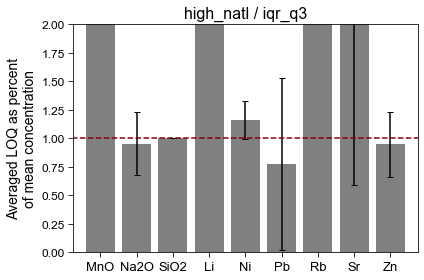

In [113]:
elem_list = ['MnO', 'Na2O', 'SiO2', 'Li', 'Ni', 'Pb', 'Rb', 'Sr', 'Zn']
vals = []
sds = []
elems = []
for element in elem_list:
    temp = []
    for atm in data.atmosphere.unique():
        for sens in data.sens_method.unique():
            df = data[(data.element==element)&
                      (data.instrument=='CL')&
                      (data.atmosphere==atm)&
                      (data.sens_method==sens)].copy(deep=True)
            
            natl_val = df[df.outlier_defn=='high_natl'].reset_index(drop=True)['loq_per_mean'][0]
            iqr_val = df[df.outlier_defn=='iqr_q3'].reset_index(drop=True)['loq_per_mean'][0]
            
            ratio =  natl_val / iqr_val
            temp.append(ratio)
    
    # get avg and std of ratio per element
    avg = statistics.mean(temp)
    sd = np.std(temp)
    
    elems.append(element)
    vals.append(avg)
    sds.append(sd)
    
out_ratios = pd.DataFrame({
    'element':elems,
    'ratio_avg':vals,
    'ratio_sd':sds
})

plt.bar(out_ratios.index, 
        out_ratios.ratio_avg, 
        yerr=out_ratios.ratio_sd, 
        tick_label=out_ratios.element,
        capsize=3,
        color='grey')
plt.tick_params(length=5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
plt.hlines(1, -1, 9, color='darkred', linestyles='dashed')
plt.title('high_natl / iqr_q3', fontsize = 16)
plt.ylabel('Averaged LOQ as percent\nof mean concentration', fontsize=14)
plt.ylim(0,2)
plt.xlim(-0.75, 8.75)
plt.tight_layout()
plt.savefig(fp + "figures\\outlier_loq_ratio.eps", dpi=600)
plt.show()

#### INSTRUMENT

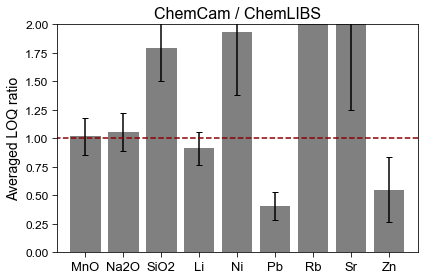

In [118]:
vals = []
sds = []
elems = []
for element in elem_list:
    temp = []
    for out in data.outlier_defn.unique():
        for sens in data.sens_method.unique():
            df = data[(data.element==element)&
                      (data.outlier_defn==out)&
                      (data.atmosphere=='Mars')&
                      (data.sens_method==sens)].copy(deep=True)
            
            cc_val = df[df.instrument=='CC'].reset_index(drop=True)['loq'][0]
            cl_val = df[df.instrument=='CL_CC'].reset_index(drop=True)['loq'][0]
            
            ratio =  cc_val / cl_val
            temp.append(ratio)
    
    # get avg and std of ratio per element
    avg = statistics.mean(temp)
    sd = np.std(temp)
    
    elems.append(element)
    vals.append(avg)
    sds.append(sd)
    
inst_ratios = pd.DataFrame({
    'element':elems,
    'ratio_avg':vals,
    'ratio_sd':sds
})

plt.bar(inst_ratios.index, 
        inst_ratios.ratio_avg, 
        yerr=inst_ratios.ratio_sd, 
        tick_label=inst_ratios.element,
        capsize=3,
        color='grey')
plt.tick_params(length=5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
plt.hlines(1, -1, 9, color='darkred', linestyles='dashed')
plt.title('ChemCam / ChemLIBS', fontsize = 16)
plt.ylabel('Averaged LOQ ratio', fontsize=14)
plt.ylim(0,2)
plt.xlim(-0.75, 8.75)
plt.tight_layout()
plt.savefig(fp + "figures\\instrument_loq_ratio.eps", dpi=600)
plt.show()

#### ATMOSPHERE

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


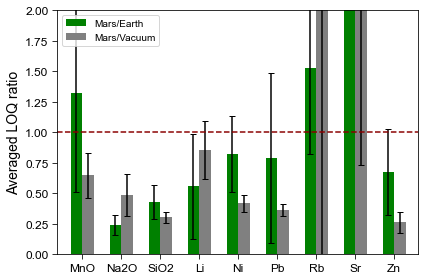

In [115]:
e_vals = []
v_vals = []
e_sds = []
v_sds = []
elems = []
for element in elem_list:
    e_temp = []
    v_temp = []
    for out in data.outlier_defn.unique():
        for sens in data.sens_method.unique():
            df = data[(data.element==element)&
                      (data.instrument=='CL')&
                      (data.outlier_defn==out)&
                      (data.sens_method==sens)].copy(deep=True)
            
            mars_val = df[df.atmosphere=='Mars'].reset_index(drop=True)['loq'][0]
            earth_val = df[df.atmosphere=='Earth'].reset_index(drop=True)['loq'][0]
            vac_val = df[df.atmosphere=='Vacuum'].reset_index(drop=True)['loq'][0]
            
            e_ratio =  mars_val / earth_val
            v_ratio = mars_val / vac_val
            
            e_temp.append(e_ratio)
            v_temp.append(v_ratio)
    
    # get avg and std of ratio per element
    e_avg = statistics.mean(e_temp)
    e_sd = np.std(e_temp)
    v_avg = statistics.mean(v_temp)
    v_sd = np.std(v_temp)
    
    elems.append(element)
    e_vals.append(e_avg)
    e_sds.append(e_sd)
    v_vals.append(v_avg)
    v_sds.append(v_sd)
    
atm_ratios = pd.DataFrame({
    'element':elems,
    'earth_avg':e_vals,
    'earth_sd':e_sds,
    'vac_avg':v_vals,
    'vac_sd':v_sds
})

# tick locations
width = 0.6
et = [i*2 for i in atm_ratios.index]
vt = [x + width for x in et]
tk = [x + width/2 for x in et]

earth = plt.bar(et, 
                atm_ratios.earth_avg, 
                yerr=atm_ratios.earth_sd, 
                width=width,
                label='Mars/Earth',
                capsize=3,
                color='green')
vac = plt.bar(vt, 
              atm_ratios.vac_avg, 
              yerr=atm_ratios.vac_sd, 
              width=width,
              label='Mars/Vacuum',
              capsize=3,
              color='grey')

plt.xticks(tk, labels=atm_ratios.element,fontsize = 12)
plt.tick_params(length=5)
plt.yticks(fontsize=12)
plt.hlines(1, -1, 17.5, color='darkred', linestyles='dashed')
plt.legend(loc='best')
plt.ylabel('Averaged LOQ ratio', fontsize=14)
plt.ylim(0,2)
plt.xlim(-1, 17.5)
plt.tight_layout()
plt.savefig(fp + "figures\\atms_loq_ratio.eps", dpi=600)
plt.show()

#### bar plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


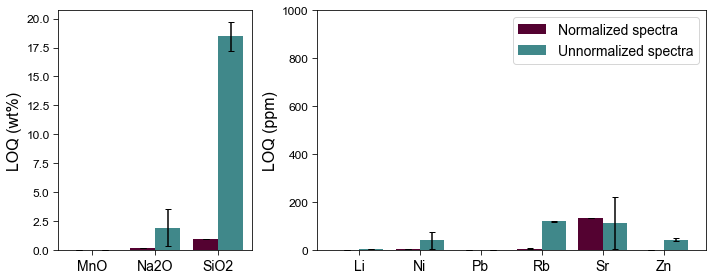

In [117]:
# specific parameters
lab1='norm3'
lab2='unnorm'
label1='Normalized spectra'
label2='Unnormalized spectra'
c_b = '#540231'
c_m = '#40888a'
on = 'normalization'
filename = 'loq_comp_norm'

df = data[(data.instrument=='CL') &
          (data.atmosphere=='Mars') &
          (data.outlier_defn=='iqr_q3') &
          (data.sens_method=='metals')
         ].copy(deep=True)

# begin general plot
maj_list = ['MnO', 'Na2O', 'SiO2']

df1 = df[df[on]==lab1].reset_index(drop=True)
df2 = df[df[on]==lab2].reset_index(drop=True)

df1_maj = pd.DataFrame(df1[df1.element.isin(maj_list)].reset_index(drop=True))
df1_min = df1[~df1.element.isin(maj_list)].reset_index(drop=True)

df2_maj = pd.DataFrame(df2[df2.element.isin(maj_list)].reset_index(drop=True))
df2_min = df2[~df2.element.isin(maj_list)].reset_index(drop=True) 

# define plot stuff
width = 0.2
cap= 3
ysize = 12
lsize = 14
tsize = 16
klen = 5

#labels
majlab = df1_maj.element
minlab = df1_min.element

# tick locations
majt1 = [0, 0.5, 1] 
majt2 = [x + width for x in majt1]
mint1 = np.arange(0,3,step=0.5)
mint2 = [x + width for x in mint1]
majtk = [x + width/2 for x in majt1]
mintk = [x + width/2 for x in mint1]

# make figure
fig, (maj, minor) = plt.subplots(ncols = 2, figsize = (10,4),
                                 # make major one smaller
                                 gridspec_kw={'width_ratios': [1,2]})
# majors
df1_major = maj.bar(majt1, df1_maj['loq'], width, yerr=df1_maj['loq_sd'], capsize=cap, label = label1, color = c_b)
df2_major = maj.bar(majt2, df2_maj['loq'], width, yerr=df2_maj['loq_sd'], capsize=cap, label = label2, color = c_m)
# minors
df1_minor = minor.bar(mint1, df1_min['loq'], width, yerr=df1_min['loq_sd'], capsize=cap, label = label1, color = c_b)
df2_minor = minor.bar(mint2, df2_min['loq'], width, yerr=df2_min['loq_sd'], capsize=cap, label = label2, color = c_m)

# formatting
maj.tick_params(axis = 'y', which = 'major', labelsize = ysize,)
maj.tick_params(length=klen)
maj.set_xticks(majtk)
maj.set_xticklabels(majlab, fontsize = lsize)
maj.set_ylabel('LOQ (wt%)', fontsize = tsize)

minor.set_xticks(mintk)
minor.set_xticklabels(minlab, fontsize = lsize)
minor.set_ylabel('LOQ (ppm)', fontsize = tsize)
minor.tick_params(axis = 'y', which = 'major', labelsize = ysize)  
minor.tick_params(length=klen)
minor.legend(handles = [df1_major, df2_major], fontsize = lsize)
minor.set_ylim(0,1000)

plt.tight_layout()
plt.savefig(fp + "figures\\"+filename+".eps", dpi=600)
plt.savefig(fp + "figures\\"+filename+".jpg", dpi=600)
plt.show()

### outlier removal
Have to do as % because different standards

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


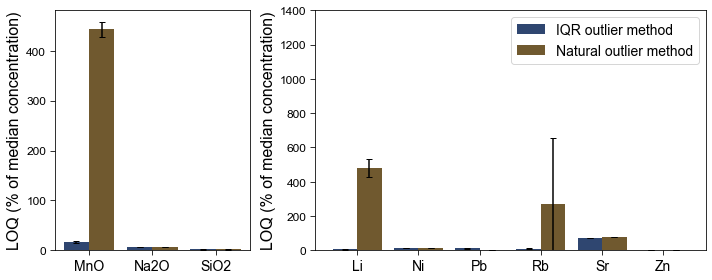

In [99]:
# specific parameters
lab1 = 'iqr_q3'
lab2 = 'high_natl'
label1='IQR outlier method'
label2='Natural outlier method'
c_b = '#2f4670'
c_m = '#70592f'
on = 'outlier_defn'
filename = 'loq_compare_outliers'

df = data[(data.instrument=='CL') &
          (data.atmosphere=='Mars') &
          (data.normalization=='norm3') &
          (data.sens_method=='metals')
         ].copy(deep=True)
        
# begin general plot
maj_list = ['MnO', 'Na2O', 'SiO2']

df1 = df[df[on]==lab1].reset_index(drop=True)
df2 = df[df[on]==lab2].reset_index(drop=True)
# convert loq to percentage of median
# IQR
df1['loq_per'] = np.nan
df1['loq_per_sd'] = np.nan
for element in df1.element:
    loq = df1[df1['element']==element]['loq'].values[0]
    loq_sd = df1[df1['element']==element]['loq_sd'].values[0]
    loq_per = (loq/iqr_means[element])*100
    loq_per_sd = (loq_sd/iqr_means[element])*100
    df1.loc[df1['element']==element, 'loq_per'] = loq_per
    df1.loc[df1['element']==element, 'loq_per_sd'] = loq_per_sd
# NATURAL
df2['loq_per'] = np.nan
df2['loq_per_sd'] = np.nan
for element in df1.element:
    loq = df2[df2['element']==element]['loq'].values[0]
    loq_sd = df2[df2['element']==element]['loq_sd'].values[0]
    loq_per = (loq/natl_means[element])*100
    loq_per_sd = (loq_sd/natl_means[element])*100
    df2.loc[df2['element']==element, 'loq_per'] = loq_per
    df2.loc[df2['element']==element, 'loq_per_sd'] = loq_per_sd

df1_maj = pd.DataFrame(df1[df1.element.isin(maj_list)].reset_index(drop=True))
df1_min = df1[~df1.element.isin(maj_list)].reset_index(drop=True)

df2_maj = pd.DataFrame(df2[df2.element.isin(maj_list)].reset_index(drop=True))
df2_min = df2[~df2.element.isin(maj_list)].reset_index(drop=True) 

# define plot stuff
width = 0.2
cap= 3
ysize = 12
lsize = 14
tsize = 16
klen = 5

#labels
majlab = df1_maj.element
minlab = df1_min.element

# tick locations
majt1 = [0, 0.5, 1] 
majt2 = [x + width for x in majt1]
mint1 = np.arange(0,3,step=0.5)
mint2 = [x + width for x in mint1]
majtk = [x + width/2 for x in majt1]
mintk = [x + width/2 for x in mint1]

# make figure
fig, (maj, minor) = plt.subplots(ncols = 2, figsize = (10,4),
                                 # make major one smaller
                                 gridspec_kw={'width_ratios': [1,2]})
# majors
df1_major = maj.bar(majt1, df1_maj['loq_per'], width, yerr=df1_maj['loq_per_sd'], capsize=cap, label = label1, color = c_b)
df2_major = maj.bar(majt2, df2_maj['loq_per'], width, yerr=df2_maj['loq_per_sd'], capsize=cap, label = label2, color = c_m)
# minors
df1_minor = minor.bar(mint1, df1_min['loq_per'], width, yerr=df1_min['loq_per_sd'], capsize=cap, label = label1, color = c_b)
df2_minor = minor.bar(mint2, df2_min['loq_per'], width, yerr=df2_min['loq_per_sd'], capsize=cap, label = label2, color = c_m)

# formatting
maj.tick_params(axis = 'y', which = 'major', labelsize = ysize,)
maj.tick_params(length=klen)
maj.set_xticks(majtk)
maj.set_xticklabels(majlab, fontsize = lsize)
maj.set_ylabel('LOQ (% of median concentration)', fontsize = tsize)

minor.set_xticks(mintk)
minor.set_xticklabels(minlab, fontsize = lsize)
minor.set_ylabel('LOQ (% of median concentration)', fontsize = tsize)
minor.tick_params(axis = 'y', which = 'major', labelsize = ysize)  
minor.tick_params(length=klen)
minor.legend(handles = [df1_major, df2_major], fontsize = lsize)
minor.set_ylim(0,1400)

plt.tight_layout()
plt.savefig(fp + "figures\\"+filename+".eps", dpi=600)
plt.savefig(fp + "figures\\"+filename+".jpg", dpi=600)
plt.show()

In [73]:
def loq_compare(on='sens_method', 
                inst='CL', 
                atm='Mars',
                out='iqr_q3',
                norm='norm3',
                sens='metals'):
    # prep data
    if on == 'sens_method':
        df = data[(data.instrument==inst) &
                  (data.atmosphere==atm) &
                  (data.normalization==norm) &
                  (data.outlier_defn==out)
                 ].copy(deep=True)
        
        lab1 = 'braga'
        lab2='metals'
        
    elif on == 'outlier_defn':
        df = data[(data.instrument==inst) &
                  (data.atmosphere==atm) &
                  (data.normalization==norm) &
                  (data.sens_method==sens)
                 ].copy(deep=True)
        
        lab1 = 'iqr_q3'
        lab2 = 'high_natl'
        
    elif on == 'normalization':
        df = data[(data.instrument==inst) &
                  (data.atmosphere==atm) &
                  (data.outlier_defn==out) &
                  (data.sens_method==sens)
                 ].copy(deep=True)
        
        lab1='norm3'
        lab2='unnorm'
        
    elif on == 'instrument':
        df = data[(data.instrument.str.contains('CC')) &
                  (data.normalization==norm) &
                  (data.atmosphere=='Mars') &
                  (data.outlier_defn==out) &
                  (data.sens_method==sens)
                 ].copy(deep=True)
        
        lab1='CC'
        lab2='CL_CC'
        
#    elif on == 'atmosphere':
#        df = data[(data.instrument=='CL') &
#                  (data.normalization==norm) &
#                  (data.outlier_defn==out) &
#                  (data.sens_method==sens)
#                 ].copy(deep=True)
        
    maj_list = ['MnO', 'Na2O', 'SiO2']
 
    df1 = df[df[on]==lab1].reset_index(drop=True)
    df2 = df[df[on]==lab2].reset_index(drop=True)

    df1_maj = pd.DataFrame(df1[df1.element.isin(maj_list)].reset_index(drop=True))
    df1_min = df1[~df1.element.isin(maj_list)].reset_index(drop=True)

    df2_maj = pd.DataFrame(df2[df2.element.isin(maj_list)].reset_index(drop=True))
    df2_min = df2[~df2.element.isin(maj_list)].reset_index(drop=True) 
    
    # define plot stuff
    width = 0.2
    c_b = '#540231'
    c_m = '#40888a'
    cap= 3
    ysize = 12
    lsize = 14
    tsize = 16
    klen = 5

    #labels
    majlab = df1_maj.element
    minlab = df1_min.element

    # tick locations
    majt1 = [0, 0.5, 1] 
    majt2 = [x + width for x in majt1]
    mint1 = np.arange(0,3,step=0.5)
    mint2 = [x + width for x in mint1]
    majtk = [x + width/2 for x in majt1]
    mintk = [x + width/2 for x in mint1]

    # make figure
    fig, (maj, minor) = plt.subplots(ncols = 2, figsize = (10,4),
                                     # make major one smaller
                                     gridspec_kw={'width_ratios': [1,2]})
    # majors
    df1_major = maj.bar(majt1, df1_maj['loq'], width, yerr=df1_maj['loq_sd'], capsize=cap, label = lab1, color = c_b)
    df2_major = maj.bar(majt2, df2_maj['loq'], width, yerr=df2_maj['loq_sd'], capsize=cap, label = lab2, color = c_m)
    # minors
    df1_minor = minor.bar(mint1, df1_min['loq'], width, yerr=df1_min['loq_sd'], capsize=cap, label = lab1, color = c_b)
    df2_minor = minor.bar(mint2, df2_min['loq'], width, yerr=df2_min['loq_sd'], capsize=cap, label = lab2, color = c_m)

    # formatting
    maj.tick_params(axis = 'y', which = 'major', labelsize = ysize,)
    maj.tick_params(length=klen)
    maj.set_xticks(majtk)
    maj.set_xticklabels(majlab, fontsize = lsize)
    maj.set_ylabel('LOQ (wt%)', fontsize = tsize)

    minor.set_xticks(mintk)
    minor.set_xticklabels(minlab, fontsize = lsize)
    minor.set_ylabel('LOQ (ppm)', fontsize = tsize)
    minor.tick_params(axis = 'y', which = 'major', labelsize = ysize)  
    minor.tick_params(length=klen)
    minor.legend(handles = [df1_major, df2_major], fontsize = lsize)
    
    plt.tight_layout()
    #plt.savefig(fp + "figures\\outlier_comp_"+metric+".eps", dpi=600)
    plt.show()

In [77]:
def rmsecv_compare(on='sens_method', 
                inst='CL', 
                atm='Mars',
                out='iqr_q3',
                norm='norm3',
                sens='metals'):
    # prep data
    if on == 'sens_method':
        df = data[(data.instrument==inst) &
                  (data.atmosphere==atm) &
                  (data.normalization==norm) &
                  (data.outlier_defn==out)
                 ].copy(deep=True)
        
        lab1 = 'braga'
        lab2='metals'
        
    elif on == 'outlier_defn':
        df = data[(data.instrument==inst) &
                  (data.atmosphere==atm) &
                  (data.normalization==norm) &
                  (data.sens_method==sens)
                 ].copy(deep=True)
        
        lab1 = 'iqr_q3'
        lab2 = 'high_natl'
        
    elif on == 'normalization':
        df = data[(data.instrument==inst) &
                  (data.atmosphere==atm) &
                  (data.outlier_defn==out) &
                  (data.sens_method==sens)
                 ].copy(deep=True)
        
        lab1='norm3'
        lab2='unnorm'
        
    elif on == 'instrument':
        df = data[(data.instrument.str.contains('CC')) &
                  (data.normalization==norm) &
                  (data.atmosphere=='Mars') &
                  (data.outlier_defn==out) &
                  (data.sens_method==sens)
                 ].copy(deep=True)
        
        lab1='CC'
        lab2='CL_CC'
        
#    elif on == 'atmosphere':
#        df = data[(data.instrument=='CL') &
#                  (data.normalization==norm) &
#                  (data.outlier_defn==out) &
#                  (data.sens_method==sens)
#                 ].copy(deep=True)
        
    maj_list = ['MnO', 'Na2O', 'SiO2']
 
    df1 = df[df[on]==lab1].reset_index(drop=True)
    df2 = df[df[on]==lab2].reset_index(drop=True)

    df1_maj = pd.DataFrame(df1[df1.element.isin(maj_list)].reset_index(drop=True))
    df1_min = df1[~df1.element.isin(maj_list)].reset_index(drop=True)

    df2_maj = pd.DataFrame(df2[df2.element.isin(maj_list)].reset_index(drop=True))
    df2_min = df2[~df2.element.isin(maj_list)].reset_index(drop=True) 
    
    # define plot stuff
    width = 0.2
    c_b = '#540231'
    c_m = '#40888a'
    cap= 3
    ysize = 12
    lsize = 14
    tsize = 16
    klen = 5

    #labels
    majlab = df1_maj.element
    minlab = df1_min.element

    # tick locations
    majt1 = [0, 0.5, 1] 
    majt2 = [x + width for x in majt1]
    mint1 = np.arange(0,3,step=0.5)
    mint2 = [x + width for x in mint1]
    majtk = [x + width/2 for x in majt1]
    mintk = [x + width/2 for x in mint1]

    # make figure
    fig, (maj, minor) = plt.subplots(ncols = 2, figsize = (10,4),
                                     # make major one smaller
                                     gridspec_kw={'width_ratios': [1,2]})
    # majors
    df1_major = maj.bar(majt1, df1_maj['rmsecv'], width, yerr=df1_maj['rmsecv_sd'], capsize=cap, label = lab1, color = c_b)
    df2_major = maj.bar(majt2, df2_maj['rmsecv'], width, yerr=df2_maj['rmsecv_sd'], capsize=cap, label = lab2, color = c_m)
    # minors
    df1_minor = minor.bar(mint1, df1_min['rmsecv'], width, yerr=df1_min['rmsecv_sd'], capsize=cap, label = lab1, color = c_b)
    df2_minor = minor.bar(mint2, df2_min['rmsecv'], width, yerr=df2_min['rmsecv_sd'], capsize=cap, label = lab2, color = c_m)

    # formatting
    maj.tick_params(axis = 'y', which = 'major', labelsize = ysize,)
    maj.tick_params(length=klen)
    maj.set_xticks(majtk)
    maj.set_xticklabels(majlab, fontsize = lsize)
    maj.set_ylabel('RMSE-CV (wt%)', fontsize = tsize)

    minor.set_xticks(mintk)
    minor.set_xticklabels(minlab, fontsize = lsize)
    minor.set_ylabel('RMSE-CV (ppm)', fontsize = tsize)
    minor.tick_params(axis = 'y', which = 'major', labelsize = ysize)  
    minor.tick_params(length=klen)
    minor.legend(handles = [df1_major, df2_major], fontsize = lsize)
    
    plt.tight_layout()
    plt.savefig(fp + "figures\\"+on+"_loq_comp.eps", dpi=600)
    plt.show()

### compare outlier methods

In [135]:
temp_data = data[(data.atmosphere == 'Mars')&
                 (data.instrument == 'ChemLIBS')&
                 (data.method == 'metals')].copy(deep=True)

In [136]:
# differences in n standards by outlier defn
temp_data.groupby(['element', 'outlier_defn']).mean()[['n_train', 'n_test']].reset_index()

,element,outlier_defn,n_train,n_test
0,Li,highest_natural,421.5,2.0
1,Li,iqr_q3,374.5,109.0
2,MnO,highest_natural,2156.0,11.0
3,MnO,iqr_q3,2120.5,674.0
4,Na2O,highest_natural,2157.0,680.0
5,Na2O,iqr_q3,2125.5,690.0
6,Ni,highest_natural,1899.5,82.5
7,Ni,iqr_q3,1619.5,350.0
8,Pb,highest_natural,1770.5,583.5
9,Pb,iqr_q3,1672.5,469.5


# Braga regions
CADILLAC ChemLIBS

In [2]:
cad = pd.read_csv(fp + "figures\\cadillac_spectra.csv")
peaks = pd.read_csv(fp + "figures\\braga_peaks.csv") 
noise = pd.read_csv(fp + "figures\\braga_noise_regions.csv") 

In [7]:
# plot defining things
height = 0.052
b_y = -.003
box_list = []
rcolor = '#8b8b8b'
base='black'
b_a =1
alpha = 0.5
lwidth=1
x_data = cad['wave']
y_data = cad['intensity']
peak_x = peaks['peak']
peak_y = peaks['intensity']
peak_labs = peaks['element']
size=70
mark="*"
mwidth=0.5
mcolor='goldenrod'
c_l = 'navy'
c_m = 'goldenrod'
llabel = 'LANL (ChemCam)'
mlabel = 'MHC (ChemLIBS)'
ysize = 12
lsize = 14
tsize = 16
klen = 5

NameError: name 'cad' is not defined

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

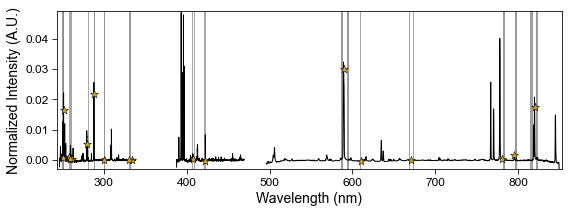

In [19]:
# get width of regions
noise['width'] = noise['stop'] - noise['start']

#make rectangles
for i in np.array(range(len(noise))):
    x = noise['start'][i]  
    width = noise['width'][i]
    box_list.append(Rectangle((x, b_y), width, height))
    
pc = PatchCollection(box_list, edgecolor = to_rgba(rcolor, alpha), facecolor=to_rgba(rcolor, alpha))
#pc = PatchCollection(box_list, hatch = '..')

# plot it all
fig, ax = plt.subplots(1, figsize = (8,3))
ax.plot(x_data, y_data, color=base, linewidth = lwidth, alpha = b_a, zorder=1) #spectrum
ax.scatter(peak_x, peak_y, facecolor = mcolor, edgecolor=base, s = size, marker = mark, linewidth = mwidth, zorder=3) # peaks
ax.add_collection(pc) # noise regions
ax.margins(x=0.005, y=0.0)
ax.set_xlabel('Wavelength (nm)', fontsize=lsize)
ax.set_ylabel('Normalized Intensity (A.U.)', fontsize = lsize)
ax.tick_params(length=klen, labelsize=ysize)

plt.tight_layout()
plt.savefig(fp + "figures\\braga_regions.eps", dpi=600)
plt.savefig(fp + "figures\\braga_regions.jpg", dpi=600)
plt.show()

# Atmosphere comparison
- Braga
- ChemLIBS
- LOQ and RMSE-P

In [26]:
data3 = data[(data.instrument == 'ChemLIBS') &
             (data.outlier_defn == 'highest_natural') &
             (data.method == 'metals')]
maj3 = data3[data3.element.isin(maj_list)].reset_index(drop=True)
min3 = data3[~data3.element.isin(maj_list)].reset_index(drop=True)

In [27]:
def maj_atm(atm, lotype):
    return maj3[maj3.atmosphere==atm][lotype]
    
def min_atm(atm, lotype):
    return min3[min3.atmosphere==atm][lotype]
    
def atmosphere(lotype):
    data = lotype
    error = lotype+'_sd'
    
    # define plot stuff
    width = 0.14
    c_m = '#a8261d'
    c_e = '#34a9c7'
    c_v = '#757778'
    ysize = 12
    lsize = 14
    tsize = 16
    cap = 3
    klen = 5

    #labels
    majlab = maj3.element.unique()
    minlab = min3.element.unique()

    # tick locations
    majt1 = [0, 0.5, 1] 
    majt2 = [x + width for x in majt1]
    majt3 = [x + width*2 for x in majt1]
    
    mint1 = np.arange(0,3,step=0.5)
    mint2 = [x + width for x in mint1]
    mint3 = [x + width*2 for x in mint1]
    
    majtk = [x + width for x in majt1]
    mintk = [x + width for x in mint1]

    # make figure
    fig, (maj, minor) = plt.subplots(ncols = 2, figsize = (10,4),
                                     # make major one smaller
                                     gridspec_kw={'width_ratios': [1,2]})
    # majors
    major1 = maj.bar(majt1, maj_atm('Mars', data), width, yerr=maj_atm('Mars', error), capsize=cap, label = "Mars", color = c_m)
    major2 = maj.bar(majt2, maj_atm('Earth', data), width, yerr=maj_atm('Earth', error), capsize=cap, label = "Earth", color = c_e)
    major3 = maj.bar(majt3, maj_atm('Vacuum', data), width, yerr=maj_atm('Vacuum', error), capsize=cap, label = "Vacuum", color = c_v)
    # minors
    minor1 = minor.bar(mint1, min_atm('Mars', data), width, yerr=min_atm('Mars', error), capsize=cap, label = "Mars", color = c_m)
    minor2 = minor.bar(mint2, min_atm('Earth', data), width, yerr=min_atm('Earth', error), capsize=cap, label = "Earth", color = c_e)
    minor3 = minor.bar(mint3, min_atm('Vacuum', data), width, yerr=min_atm('Vacuum', error), capsize=cap, label = "Vacuum", color = c_v)

    # formatting
    maj.tick_params(axis = 'y', which = 'major', labelsize = ysize)
    maj.tick_params(length=klen)
    maj.set_xticks(majtk)
    maj.set_xticklabels(majlab, fontsize = lsize)
    maj.set_ylabel((lotype + " (wt%)"), fontsize = tsize)

    minor.set_xticks(mintk)
    minor.set_xticklabels(minlab, fontsize = lsize)
    minor.set_ylabel((lotype + " (ppm)"), fontsize = tsize)
    minor.tick_params(axis = 'y', which = 'major', labelsize = ysize)  
    minor.tick_params(length=klen)
    minor.legend(handles = [major1, major2, major3], fontsize = lsize)

    # save image
    path = fp + "figures\\"+lotype+"_atmosphere_new_metals.eps"
    path1 = fp + "figures\\"+lotype+"_atmosphere_new_metals.jpeg"
    plt.savefig(path, bbox_inches="tight") # save as .eps
    plt.savefig(path1, bbox_inches="tight") # save as .jpeg
    
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


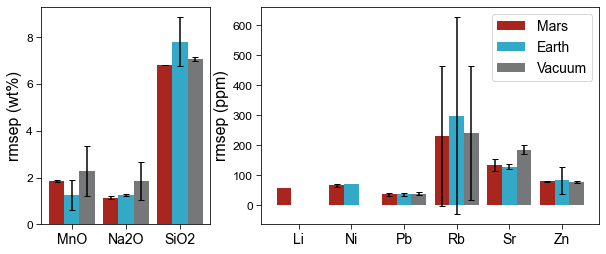

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


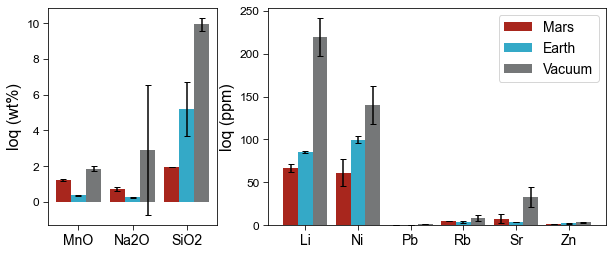

In [28]:
atmosphere('rmsep')
atmosphere('loq')

# All predicted vs. true and regression vector plots

#### Pred v. true

In [29]:
# make dictionary of 'Actual' uncertainties
unc_path = fp + "BureauVeritasuncertainties_forpaper.csv"
uncert = pd.read_csv(unc_path)
uncert = pd.Series(uncert.uncertainty.values, index=uncert.element).to_dict()

In [115]:
def pred_true_plot(folder_name, data, outlier, method):
#-------------------------GET-DATA--------------------------#
    folder = fp+'python_models\\'+folder_name+"\\"

    for file in tqdm(os.listdir(folder), desc = folder_name+' plots', leave=False):

        if outlier+"_"+method+'_test' in file:
            
            path = (folder + file)
            df = pd.read_csv(path)
            df = df[~df.pred.astype(str).str.contains('<LOQ|>100 wt%')]
            df.pred = df.pred.astype(float)
            
            element = file.split('_')[0]
            
            # get LDBQ
            temp = data[data.element==element]
            if method == 'braga':
                temp = temp[temp.method=='braga']
                c = '#3a2382'
            elif method == 'metals':
                temp = temp[temp.method=='metals']
                c = '#f58442'
            
            loq = temp['loq'].iloc[0]
            lob = temp['lob'].iloc[0]
            lod = temp['lod'].iloc[0]

#----------------------------MAKE-PLOT------------------------------#
            xlab = "True "+element
            ylab = "Predicted "+element
            xdata = df.actual
            ydata = df.pred
            xerr = uncert[element] # 'Actual' uncertainty
            yerr = temp['rmsep'].iloc[0] 

            b_type = 'dotted'
            d_type = 'dashed'
            q_type = 'solid'
            ddash = (0, (10, 2))
            c_p = "black"
            c_g = "darkgrey"
            c_e = "#bfbfbf"
            linew = 0.5
            line_c = 'white'
            lwidth = 1.5
            cap = 2.5
            xsize = 20
            klen = 5
            tsize = 16

            fig, ax = plt.subplots(1, figsize = (6,6))
            # plot data
            ax.scatter(xdata, ydata, c=c_p, linewidth = linew, edgecolors = line_c, zorder=2)
            # error bars
            ax.errorbar(x=xdata, y=ydata, c=c_e, xerr=xerr, yerr=yerr, fmt = '.', capsize=cap, zorder=1)
            # 1:1 line
            y_bot, y_top = plt.ylim() # get current auto-axes
            x_bot, x_top = plt.xlim()
            # make sure LDBQ not below edge
            top = max(y_top, x_top, loq+(0.1*loq))
            bot = min(y_bot, x_bot, 0)
            plt.xlim(x_bot, x_top) # reset to original axes
            plt.ylim(y_bot, y_top)
            one_one = ax.plot([bot,top], [bot,top], c=c_p, linewidth=lwidth, linestyle = ddash, label = "1:1")

            # plot lines
            zero = ax.axhline(y=0, xmin=0, xmax=1, c=c_p, linewidth=1, linestyle = q_type)
            lob_line = ax.axhline(y=lob, xmin = 0, xmax = 1, c=c, linewidth=lwidth, linestyle = b_type, label = "Braga LOB")
            lod_line = ax.axhline(y=lod, xmin = 0, xmax = 1, c=c, linewidth=lwidth, linestyle = d_type, label = "Braga LOD")
            loq_line = ax.axhline(y=loq, xmin = 0, xmax = 1, c=c, linewidth=lwidth, linestyle = q_type, label = "Braga LOQ")

            # format
            ax.set_xlabel(xlab, fontsize = xsize)
            ax.set_ylabel(ylab, fontsize = xsize)
            ax.tick_params(length=klen, labelsize=tsize)

            plt.tight_layout()
            plt.savefig(fp + "figures\\new_pred_true\\"+folder_name+"\\"+element+"_"+method+".eps", dpi=600)
            plt.savefig(fp + "figures\\new_pred_true\\"+folder_name+"\\"+element+"_"+method+".jpg", dpi=600)
            plt.close(fig)

#### Regression vector

In [119]:
cl_key = pd.read_csv(fp+'CL_all_Mars_spectra.csv', usecols=[0])
cc_key = pd.read_csv(fp+'CC_all_Mars_spectra.csv', usecols=[0])

In [132]:
def reg_plot(folder_name, temp, outlier, method):
#-------------------------GET-DATA--------------------------#
    folder = fp+'python_models\\'+folder_name+"\\"
    inst = folder_name.split('_')[0]

    for file in tqdm(os.listdir(folder), desc = folder_name+' plots', leave=False):

        if outlier+'_coeff' in file:
            path = (folder + file)
            df = pd.read_csv(path)
    
            element = file.split('_')[0]

#----------------------------MAKE-PLOT------------------------------#
            path_name = instrument+"_"+atmosphere+"\\"
            fig_name = element+"_"+n_range
            
            if inst == 'CL':
                xdata = cl_key['wave']
            elif inst == 'CC':
                xdata = cc_key['wave']
            ydata = df['0']
            c_p = 'black'
            xlab = 'Wavelength (nm)'
            ylab = 'Weight (A.U.)'
            title = element+": "+instrument+" "+atmosphere+" "+n_range
            xsize=20
            tsize = 16
            klen = 5

            fig, ax = plt.subplots(1, figsize = (10,6))
            ax.plot(xdata, ydata, c = c_p)
            ax.set_xlabel(xlab, fontsize = xsize)
            ax.set_ylabel(ylab, fontsize = xsize)
            ax.tick_params(length=klen, labelsize=tsize)
            plt.title(title, fontsize=tsize)

            # save
            plt.tight_layout()
            plt.savefig(fp + "figures\\new_regression_vectors\\"+folder_name+"\\"+element+"_"+method+".eps", dpi=600)
            plt.savefig(fp + "figures\\new_regression_vectors\\"+folder_name+"\\"+element+"_"+method+".jpg", dpi=600)
            plt.close(fig)

In [133]:
envs = [['LANL', 'Mars'],['ChemLIBS', 'Mars'],['ChemLIBS', 'Earth'],['ChemLIBS', 'Vacuum']]
inst_alias = {'ChemLIBS':'CL','LANL':'CC'}

outlier = 'highest_natural'
method = 'braga'

for env in envs:
    
    instrument = env[0]
    atmosphere = env[1]
    
    for n_range in ['0-750', '250-1000']:
        
        temp = detail_data[(detail_data.instrument == instrument) &
                           (detail_data.atmosphere == atmosphere) &
                           (detail_data.outlier_defn == outlier) &
                           (detail_data.num_range == n_range)]
        
        folder_name = "{}_{}_{}\\".format(inst_alias[instrument], atmosphere, n_range)
        
        #pred_true_plot(folder_name, temp, outlier, method)
        reg_plot(folder_name, temp, outlier, method)

CC_Mars_0-750\ plots:   0%|          | 0/105 [00:00<?, ?it/s]

CC_Mars_250-1000\ plots:   0%|          | 0/103 [00:00<?, ?it/s]

CL_Mars_0-750\ plots:   0%|          | 0/105 [00:00<?, ?it/s]

CL_Mars_250-1000\ plots:   0%|          | 0/105 [00:00<?, ?it/s]

CL_Earth_0-750\ plots:   0%|          | 0/103 [00:00<?, ?it/s]

CL_Earth_250-1000\ plots:   0%|          | 0/105 [00:00<?, ?it/s]

CL_Vacuum_0-750\ plots:   0%|          | 0/101 [00:00<?, ?it/s]

CL_Vacuum_250-1000\ plots:   0%|          | 0/101 [00:00<?, ?it/s]